**Image Classification: Plant Seedlings Classification using Convolutional Neural Networks and Transfer Learning**
<br><br>We will use a pre-trained state-of-the-art CNN architecture, Xception, to classify various species of crop seedlings taken at several growth stages. The ability to do so effectively can mean better crop yields and better stewardship of the environment.
<br>-The inputs will be plant seedling images. We will use the Keras deep learning library and supported functionalities for our deep learning model.
<br>-4,750 training and validation examples, 794 test examples
<br>-12 classes of plant species
<br>-(X,Y) supervised learning dataset where X is the input image and Y is the ground-true class label
<br><br><u>Methodology:</u>
<br>-Use a pre-trained CNN, Xception, to extract an input image's feature-learned-representation-vector during forward-pass
<br>-Take said representation from the CNN architecture's "bottleneck" layer
<br>-Run the extracted feature-representation-vectors through a linear Logistic Regression classifier for prediction purposes
<br><br><u>Notes:</u>
<br>-Instead of extracting the bottleneck feature-vector then running it through a [separate] LR classifier, we could alternatively have appended another fully-connected layer to the end of the CNN. This would have likely produced better results, but would be more time-consuming and resource-intensive to train and fine-tune. Classifying the feature-representations via a simple logistic regression classifier provides a good starting baseline
<br><br><u>Sources:</u>
<br>Kaggle Challenge Competition: https://www.kaggle.com/c/plant-seedlings-classification
<br>Plant Seedlings Dataset and Paper: https://vision.eng.au.dk/plant-seedlings-dataset/ | https://arxiv.org/abs/1711.05458
<br>Keras Pre-trained Models: https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet

**Import Dependencies**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

import os
from tqdm import tqdm # Fancy progress bars

import seaborn as sns
from keras.preprocessing import image
from keras.applications import xception
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Our data files are available in the "../input/" directory.
print(os.listdir("../input"))
# For Kaggle kernel purposes any results we write to the current directory is saved as output.

Using TensorFlow backend.


['plant-seedlings-classification', 'keras-pretrained-models']


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

**Loading up Keras Pretrained Models into Kaggle Kernels**

In [3]:
# This project was done in Kaggle Kernels, where we'd need to copy the Keras pretrained models
# into the cache directory (~/.keras/models) where keras is looking for them

# Display the pretrained models that we have prepared in our file directory
!ls ../input/keras-pretrained-models/

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
# Create keras cache directories in Kaggle Kernels to load the pretrained models into
cache_dir = os.path.expanduser(os.path.join('~', '.keras')) # Cache directory
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models') # Models directory
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [5]:
# Copy a selection of our pretrained models files onto the keras cache directory so Keras can access them
!cp ../input/keras-pretrained-models/xception* ~/.keras/models

In [6]:
# Display our pretrained models that are located in the keras cache directory
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [7]:
!ls ../input/plant-seedlings-classification

sample_submission.csv  test  train


**Preparing the Dataset for the Model**

In [8]:
# Define Y-labels and NUM_CLASSES
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
             'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [9]:
SAMPLE_PER_CATEGORY = 200
SEED = 7
data_dir = '../input/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

print(train_dir)
print(test_dir)

../input/plant-seedlings-classification/train
../input/plant-seedlings-classification/test


In [10]:
sample_submission.head(10)

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet
5,00d090cde.png,Sugar beet
6,00ef713a8.png,Sugar beet
7,01291174f.png,Sugar beet
8,026716f9b.png,Sugar beet
9,02cfeb38d.png,Sugar beet


In [11]:
# Displaying the training data: Note that the training images are organized into sub-folders within the main folder,
# organized by plant species. Hence, we are simply calling each directory name and printing out their lengths

for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))
    # "Print length of this directory -- an integer output"

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


**Creating Our Aggregate Training Sample for the CNN:**

In [12]:
# We are going to do a traversal over the directories and folders containing the training set data in order 
# to collate all the image-files and their corresponding class index and class_names into an aggregate training-set
# collection, and convert it into a pandas DataFrame.

# Note that this step simply concerns with aggregating the data (i.e.: filenames) and their labels.
# We have not "unpacked" each example into its image-3D-matrix yet.

train = []
for category_id, category in enumerate(CATEGORIES): # category_id is the integer index corresponding to each class_name
    for file in os.listdir(os.path.join(train_dir, category)): # Means: "for every "file" in this directory,:"
        train.append(['train/{}/{}'.format(category, file), category_id, category]) # Renaming the file names and
        # adding to the train list
train = pd.DataFrame(train, columns = ['file', 'category_id', 'category']) # Define a pandas DataFrame over training data
train.head(5) # Print preview of the training DataFrame
train.shape # Check shape: should be of dims (m, 3), where 3 represents file_name, category_id (int index), and class_name
# for each example

,file,category_id,category
0,train/Black-grass/abe0f4751.png,0,Black-grass
1,train/Black-grass/c1a625098.png,0,Black-grass
2,train/Black-grass/6b9ebf8cc.png,0,Black-grass
3,train/Black-grass/898ecfa78.png,0,Black-grass
4,train/Black-grass/eac39cfa8.png,0,Black-grass


(4750, 3)

**Creating Our Training Set**

In [13]:
# Remember: as this point, "train" is a pandas DataFrame object

train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1) # pandas function for returning a random sample of items from an axis
# in this case, axis defaults to =0
# The function can either return a specified number of random sample items, or a fraction of them from the selected axis
# frac=1 means we want all of it
train.index = np.arange(len(train)) # This specifies the DataFrame's index (the leftmost "column" counter for m)
train.head(5)
train.shape # Should be same as above, but m decreased due to us selected a random sample from the aggregate training-set

,file,category_id,category
0,train/Loose Silky-bent/82e4a193e.png,6,Loose Silky-bent
1,train/Black-grass/6afa7c717.png,0,Black-grass
2,train/Black-grass/163c13912.png,0,Black-grass
3,train/Scentless Mayweed/ddb46795d.png,8,Scentless Mayweed
4,train/Shepherds Purse/953ced7c6.png,9,Shepherds Purse


(2400, 3)

**Creating Our Test Set**

In [14]:
# Similar procedure to creating the training set
# Remember, the test examples are NOT labeled; the labels are not provided for competition purposes
# So, the purpose of this is primarily to collate all the test examples into a neatly organized pandas DataFrame with
# appropriate headers

# Also note that the column 'filepath' is equivalent to the column 'file' in the training set DataFrame

test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(5)
test.shape # We would expect (m, 2) with m being the number of test examples, and 2 being the filepath and file columns

,filepath,file
0,test/36d62bf36.png,36d62bf36.png
1,test/de0b79659.png,de0b79659.png
2,test/41f1c3cdb.png,41f1c3cdb.png
3,test/39d569be4.png,39d569be4.png
4,test/b2706e2b3.png,b2706e2b3.png


(794, 2)

**Reading an Image to an Array**

In [15]:
# Image is a keras.preprocessing object containing function for preprocessing images for use in keras / tf models
# Essentially, converting images into their corresponding 3-D numpy arrays

# The data_dir is the root-project directory, and the filepaths we have set up nicely when preparing our datasets-in-name
# Thus here, all we have to do is concat the filepaths, and the function will spit out the image file's array format
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size = size)
    img = image.img_to_array(img)
    return img

**Loading and Visualizing Sample Images (Training Examples)**

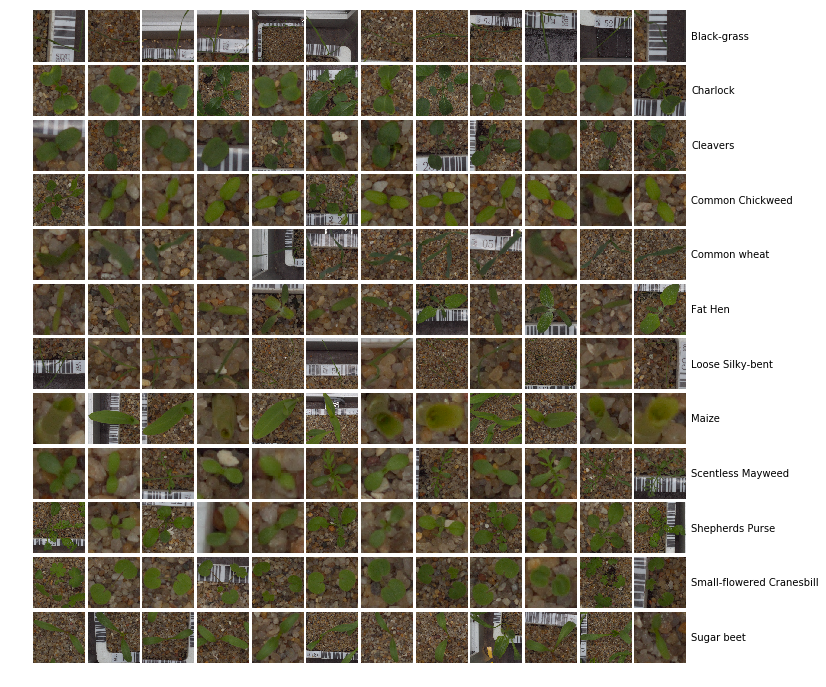

In [16]:
# Using matplotlib for this

fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES)) # Displaying a square matrix with num_categories number of
# images for each category, across all categories
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05) # Set-up grid using 'fig'
i = 0 # Initialize counter

# Iterate through the files in the categories
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224,224)) # read_img function call; filepath specified, img_size hard-coded
        ax.imshow(img/255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1: # Labeling the row-categories (I believe)
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

**Train-Validation Split**

In [17]:
# A bit more sophisticated / randomized method of splitting train-dev than simply picking the split index to be
# len(trainset) * split_percentage

np.random.seed(seed=SEED)
rnd = np.random.random(len(train)) # Returns a list of len(train) of 'continuous uniform'
# random distribution floats b/t [0.0, 1.0)
train_idx = rnd < 0.8 # Indices in which rnd is <0.8 (which should come out to roughly 80% of the dataset)
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values # pandas function calls
yv = train.loc[valid_idx, 'category_id'].values
len(ytr)
len(yv)

1925

475

**Run Examples through the Pre-trained Xception Model to Extract Xception Features / Representations:  
(pre-classification step)**

In [18]:
# Specify parameters:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
# Initialize aggregate trainset object of shape (m_total, height, width, channels)

# Fill the numpy array with image files converted into their image-3D arrays
for i, file in tqdm(enumerate(train['file'])): # tqdm is a progress bar
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE)) # Read the filepath into an array via our function call
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0)) # Pre-process that into a format for Xception model
    x_train[i] = x # Set the i-th example in our initialized zero-4D-array to the particular example
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [00:42, 39.34it/s]

Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [19]:
# Split X into training and validation, now that we have loaded the actual image arrays into x_train

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape)) # Print shapes to confirm dims are correct

((1925, 299, 299, 3), (475, 299, 299, 3), (1925,), (475,))


In [20]:
# Forward propagation through pre-trained Xception model for feature-extraction
# Note: No classification yet in this step

xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING) # Define Xception object
    # based on "off-the-shelf" pre-trained Xception model
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1) # Fwdprop through Xception for feature-extraction
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)

# Check output dims:
print("Xception train bottleneck-features shape: {} size: {:,}".format(train_x_bf.shape, train_x_bf.size))
print("Xception valid bottleneck-features shape: {} size: {:,}".format(valid_x_bf.shape, valid_x_bf.size))

Instructions for updating:
Colocations handled automatically by placer.
475/475 [==============================] - 214s 450ms/step
Xception train bottleneck-features shape: (1925, 2048) size: 3,942,400
Xception valid bottleneck-features shape: (475, 2048) size: 972,800


**LogReg Classification on ("using") Resulting Xception-bottleneck Features:**

In [21]:
# Define logistic regression object (that we have imported via sk-learn)

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr) # We need to fit the classifier to our (X,Y pairs)
valid_probs = logreg.predict_proba(valid_x_bf) # Classification on our dev set -- probabilities of various classes
valid_preds = logreg.predict(valid_x_bf) # Classification on our dev set -- predicted classes

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=7, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
# accuracy_score is an object we've imported from sk-learn

print("Validation Xception Accuracy: {}".format(accuracy_score(yv, valid_preds)))

Validation Xception Accuracy: 0.8357894736842105


**Illustrating the Results: Confusion Matrix**

In [23]:
cnf_matrix = confusion_matrix(yv, valid_preds) # Confusion matrix imported from sk-learn
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


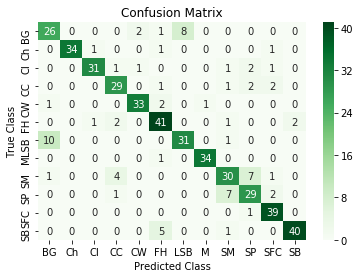

In [24]:
# Plotting the confusion matrix to illustrate correct and incorrect predictions

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

**Finalization and Creating the Submission**

In [25]:
# Creating the X input objects for the test data
# (similar to how we constructed the 4D input x_train from the filepath object)

x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print("Test images dataset shape: {} size: {:,}".format(x_test.shape, x_test.size))

794it [00:06, 127.15it/s]

Test images dataset shape: (794, 299, 299, 3) size: 212,953,182


In [26]:
# Run forwardprop on the test set input through Xception to get encoded-feature-representation

test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))

# Run encoded-feature-representations through the Logistic-Regression classifier (by sk-learn)

test_preds = logreg.predict(test_x_bf)

794/794 [==============================] - 346s 435ms/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [27]:
# Note: test_preds have shape of (794, 1) that corresponds to the class for each of the test examples

# Creating the submission file

test['category_id'] = test_preds
test['species'] = [CATEGORIES[c] for c in  test_preds]
test[['file', 'species']].to_csv('submission.csv', index=False)